# In this notebook we will show how `trackio` can be used to process and analyze any kind of Agent Based Model (ABM) output.

## This output is for ABM modelling of North Atlantic Right Whales that was done in [DHI's MIKE ECOLAB](https://www.mikepoweredbydhi.com/products/mike-eco-lab).

## Please note, the output of this model was converted to CSV prior to running this notebook.

In this notebook we will:

* Read the data
* Group points by individual agents
* Split tracks based on unique track identifiers in the data
* Reproject the data CRS
* Plot the data
* Develop a distribution of time spent in behaviour modes
* Develop a time series of agent migrations through zonal analysis
* Develop monthly heatmaps of track density
* Perform a proximity analysis
* Find the two agents that spent the most time close to eachother
___

In [1]:
import trackio as tio
import rasterio as rio
from rasterio.plot import show
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gp
import glob
import os

## The CSV file contains `X`, `Y`, `Time`, `Whale_ID`, `Track ID` and `Status` columns. So, we do not need to do any column mapping since the mandatory columns (`X`, `Y`, `Time`) are already included.

In [2]:
#create the dataset
ds = tio.read(raw_files=['./ABM_output.csv'],
              data_path='whale_data')


No dataset.db found in c:\code\trackio\notebooks\example2_ABM_output\whale_data. 
Using default units/crs. 
Edit self.meta and then run self.refresh_meta to update.



## Now let's group the points.

In [3]:
#group the points by agent
ds = ds.group_points(groupby='Whale_ID',              
                     meta_cols=['Whale_ID'],
                     data_cols=['Time',
                                'X',
                                'Y',
                                'Status',
                                'Track_ID'],
                     prefix='',
                     ncores=1)

Grouping points: 100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


## Now let's split the points into tracks.

Here, there's a unique identifier for each track. In fact, there is only 1 track per agent. In this case, we can use the `Track_ID` column to split the points into tracks for each agent.

In [4]:
#split using spatiotemporal thresholds
ds = ds.split_tracks_by_data(data_col='Track_ID')

Splitting tracks by changes in data column: 100%|██████████| 10/10 [00:00<00:00, 64.01it/s]


## Let's also reproject so we can calculate some fields easier later on

In [5]:
#reproject to UTM-20N
ds = ds.reproject_crs(32620)

Reprojecting CRS: 100%|██████████| 10/10 [00:00<00:00, 84.68it/s]


In [6]:
#refresh the metadata
ds = ds.refresh_meta()

Refreshing metadata: 100%|██████████| 10/10 [00:00<00:00, 65.53it/s]


New meta/databases saved to c:\code\trackio\notebooks\example2_ABM_output\whale_data


In [7]:
ds.agents.head(5)

,Whale_ID,npoints,ntracks,Xmin,Xmax,Ymin,Ymax,Start Time,End Time,File,geometry
Agent ID,,,,,,,,,,,
NARW-agent2,NARW-agent2,21458,1,60861.680633,843342.13966,4498647.730452,5407151.613047,2017-04-20 00:30:00,2017-11-29 12:45:00,c:\code\trackio\notebooks\example2_ABM_output\...,"POLYGON ((843342.140 4498647.730, 843342.140 5..."
NARW-agent4,NARW-agent4,22180,1,-78254.886666,946016.434956,4471115.388961,5351898.303068,2017-04-20 00:30:00,2017-12-07 01:15:00,c:\code\trackio\notebooks\example2_ABM_output\...,"POLYGON ((946016.435 4471115.389, 946016.435 5..."
NARW-agent5,NARW-agent5,352,1,-44260.279616,26944.193434,4530896.800305,4647106.219466,2017-04-20 00:30:00,2017-04-23 16:15:00,c:\code\trackio\notebooks\example2_ABM_output\...,"POLYGON ((26944.193 4530896.800, 26944.193 464..."
NARW-agent3,NARW-agent3,22330,1,18492.062268,806025.17641,4557959.906777,5379480.49142,2017-04-20 00:30:00,2017-12-08 14:45:00,c:\code\trackio\notebooks\example2_ABM_output\...,"POLYGON ((806025.176 4557959.907, 806025.176 5..."
NARW-agent1,NARW-agent1,24102,1,75389.211771,877440.098214,4415462.679722,5357771.896847,2017-04-20 00:30:00,2017-12-27 01:45:00,c:\code\trackio\notebooks\example2_ABM_output\...,"POLYGON ((877440.098 4415462.680, 877440.098 5..."


In [8]:
ds.tracks.head(5)

,Whale_ID,Agent ID,npoints,Xmin,Xmax,Ymin,Ymax,Start Time,End Time,File,...,Yend,Effective Distance,Min Temporal Resolution,Mean Temporal Resolution,Max Temporal Resolution,Min Spatial Resolution,Mean Spatial Resolution,Max Spatial Resolution,Sinuosity,geometry
Track ID,,,,,,,,,,,,,,,,,,,,,
NARW-agent2_T0,NARW-agent2,NARW-agent2,21458,60861.680633,843342.139660,4.498648e+06,5.407152e+06,2017-04-20 00:30:00,2017-11-29 12:45:00,c:\code\trackio\notebooks\example2_ABM_output\...,...,4.500889e+06,458256.049365,900,900.0,900,8.780680,1834.129352,6982.431049,85.879747,"POLYGON ((843342.140 4498647.730, 843342.140 5..."
NARW-agent4_T0,NARW-agent4,NARW-agent4,22180,-78254.886666,946016.434956,4.471115e+06,5.351898e+06,2017-04-20 00:30:00,2017-12-07 01:15:00,c:\code\trackio\notebooks\example2_ABM_output\...,...,4.601503e+06,94124.060482,900,900.0,900,12.558567,1845.227968,6357.664258,434.801802,"POLYGON ((946016.435 4471115.389, 946016.435 5..."
NARW-agent5_T0,NARW-agent5,NARW-agent5,352,-44260.279616,26944.193434,4.530897e+06,4.647106e+06,2017-04-20 00:30:00,2017-04-23 16:15:00,c:\code\trackio\notebooks\example2_ABM_output\...,...,4.539350e+06,112694.418459,900,900.0,900,104.562846,1421.138175,3195.472386,4.426302,"POLYGON ((26944.193 4530896.800, 26944.193 464..."
NARW-agent3_T0,NARW-agent3,NARW-agent3,22330,18492.062268,806025.176410,4.557960e+06,5.379480e+06,2017-04-20 00:30:00,2017-12-08 14:45:00,c:\code\trackio\notebooks\example2_ABM_output\...,...,4.561978e+06,628350.377736,900,900.0,900,12.669856,1869.420538,6993.616235,66.431553,"POLYGON ((806025.176 4557959.907, 806025.176 5..."
NARW-agent1_T0,NARW-agent1,NARW-agent1,24102,75389.211771,877440.098214,4.415463e+06,5.357772e+06,2017-04-20 00:30:00,2017-12-27 01:45:00,c:\code\trackio\notebooks\example2_ABM_output\...,...,4.415463e+06,316029.883224,900,900.0,900,8.669095,1819.379029,6974.192915,138.749075,"POLYGON ((877440.098 4415462.680, 877440.098 5..."


In [9]:
ds.tracks[['Start Time','End Time','Duration']]

,Start Time,End Time,Duration
Track ID,,,
NARW-agent2_T0,2017-04-20 00:30:00,2017-11-29 12:45:00,19311300
NARW-agent4_T0,2017-04-20 00:30:00,2017-12-07 01:15:00,19961100
NARW-agent5_T0,2017-04-20 00:30:00,2017-04-23 16:15:00,315900
NARW-agent3_T0,2017-04-20 00:30:00,2017-12-08 14:45:00,20096100
NARW-agent1_T0,2017-04-20 00:30:00,2017-12-27 01:45:00,21690900
NARW-agent9_T0,2017-04-20 00:30:00,2017-05-11 08:00:00,1841400
NARW-agent7_T0,2017-04-20 00:30:00,2017-12-18 05:30:00,20926800
NARW-agent10_T0,2017-04-20 00:30:00,2017-04-21 15:15:00,139500
NARW-agent6_T0,2017-04-20 00:30:00,2017-12-10 03:45:00,20229300


## Some basic information about the data


In [10]:
print(len(ds.agents), 'Agents')
print(len(ds.tracks), 'Tracks')
print(ds.agents.npoints.sum(), 'Points')
print('From', ds.agents['Start Time'].min(), 'to', ds.agents['End Time'].max())
print('Mean Spatial Resolution', ds.tracks['Mean Spatial Resolution'].mean(), 'm')
print('Mean Temporal Resolution', ds.tracks['Mean Temporal Resolution'].mean(), 's')

10 Agents
10 Tracks
138667 Points
From 2017-04-20 00:30:00 to 2017-12-27 01:45:00
Mean Spatial Resolution 1840.072603121985 m
Mean Temporal Resolution 900.0 s


## Let's plot them quickly on a basemap


In [11]:
#Convert to GeoDataFrame.. here you can export to software like QGIS to play with the data
gdf = ds.to_gdf()

Converting tracks to GeoDataFrame: 100%|██████████| 10/10 [00:00<00:00, 23.59it/s]


<Axes: >

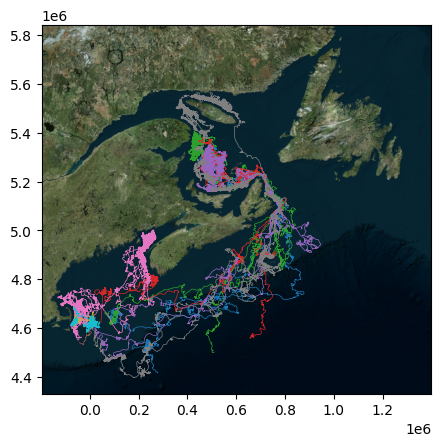

In [12]:
#plot
plt.figure()
bm = rio.open('basemap.tif', 'r')
ax = show(bm, zorder=0, ax=plt.gca())
gdf.plot(column='Whale_ID', ax=plt.gca(), zorder=1, linewidth=0.5)

## Let's develop a distribution of time spent in each status/behaviour mode. Here, the timestep is constant in the data, so the % of time spent in any mode would simply be the sum of the points in that mode divided by the total number of points.

Here:

1 = Milling

2 = Foraging

3 = Feeding

4 = Resting

5 = Migrating


In [13]:
#create a counting function
def count_time_each_mode(agent):
    #get the track data
    all_tracks = agent.data
    #get the statuses
    all_status = all_tracks['Status']
    #count number of timesteps for each status
    mode_counts = all_status.value_counts().to_dict()
    #convert to relative
    for mode,count in mode_counts.items():
        mode_counts[mode] = count/len(all_status)
    return agent.agent_meta['Agent ID'], mode_counts

In [14]:
#convert dataset to dask bag and run the function
result = ds.to_dask_bag().map(count_time_each_mode).compute()

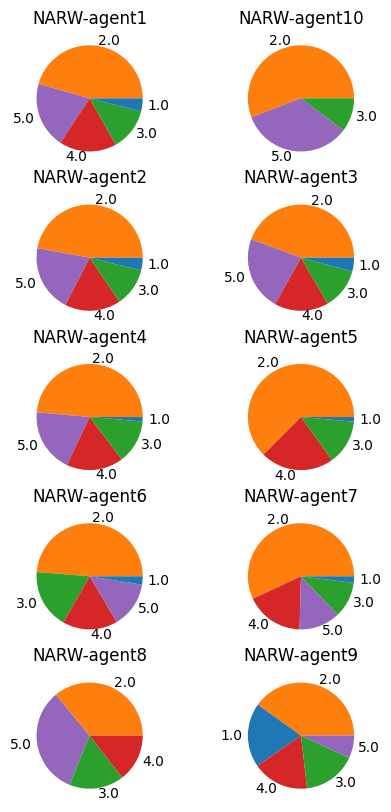

In [15]:
#create plot
fig, ax = plt.subplots(5, 2, figsize=(5,10))

#constant color mapper
c = {i+1:f'C{i}' for i in range(5)}

#loop through each agent and plot distribution
for i, a in enumerate(ax.flatten()):
    agent_id, counts = result[i]
    df = pd.DataFrame([counts]).T
    df.plot.pie(y=0, ax=a, ylabel='', colors=[c[i] for i in df.index])
    a.set_title(agent_id)
    a.legend().remove()

## Since it's not a huge amount of data, let's quickly calculate the relative distance travelled along each track and plot it. Since the agents are migrating to/from their destination during this simulation, this plot should reveal the general travel pattern.

In [16]:
#compute distance travelled
ds = ds.compute_distance_travelled(relative=True)

#get points
pts = ds.to_df()

Converting tracks to DataFrame: 100%|██████████| 10/10 [00:00<00:00, 85.94it/s]


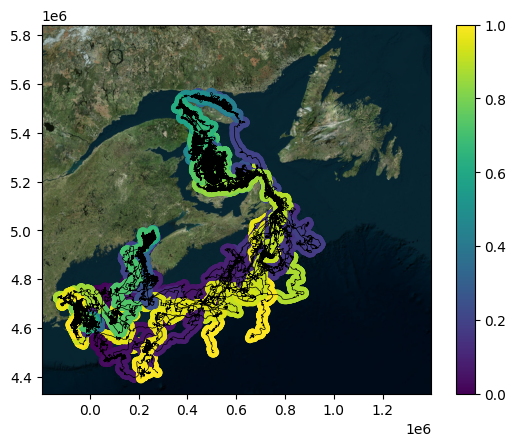

In [17]:
#plot
plt.figure()
bm = rio.open('basemap.tif', 'r')
ax = show(bm, zorder=0, ax=plt.gca())
mappable = ax.scatter(pts['X'], pts['Y'], c=pts['Distance Travelled'])
gdf.plot(color='k', ax=plt.gca(), zorder=1, linewidth=0.5)
plt.colorbar(mappable)

## From the image, it appears the agents start in the SW corner, migrate to the north, and then return to the SW corner.

## Now, lets do some zonal analysis on the data to develop a time series of migration across the model domain, in both directions (i.e. arriving and departing).

In [18]:
#read the polygons
polygons = gp.read_file('polygons.gpkg')

## These polygons represent approximately 50 NM segments of the migratory path.

<Axes: >

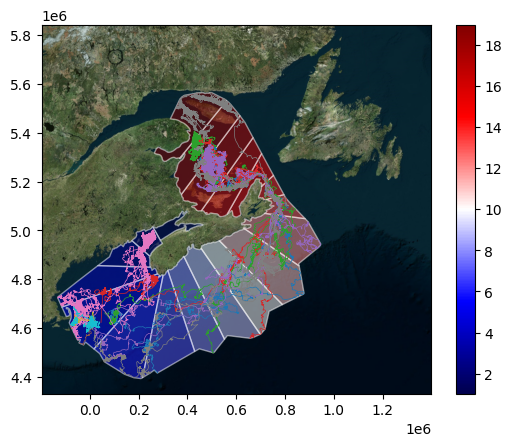

In [19]:
#visualize the polygons
plt.figure()
bm = rio.open('basemap.tif', 'r')
ax = show(bm, zorder=0, ax=plt.gca())
gdf.plot(column='Whale_ID', ax=ax, zorder=1, linewidth=0.5)
polygons.plot(ax=ax, column='Code', alpha=0.5, zorder=0, edgecolor='w', cmap='seismic', legend=True)

## Now lets classify the tracks when they're in each polygon.

In [20]:
#classify in polygons
ds = ds.classify_in_polygons(polygons, to_codes=False)

Classifying tracks inside polygons: 100%|██████████| 10/10 [00:00<00:00, 12.86it/s]


In [21]:
#convert to dataframe
df = ds.to_df()

Converting tracks to DataFrame: 100%|██████████| 10/10 [00:00<00:00, 83.52it/s]


## For arriving, let's just use the first time an agent was observed at each waypoint/slice. For departing, just use the max.

In [22]:
mins = df.groupby(['Agent ID', 'Polygon'])['Time'].agg(min)
maxs = df.groupby(['Agent ID', 'Polygon'])['Time'].agg(max)
migrations = pd.concat([mins, maxs])

## Let's plot the migrations.

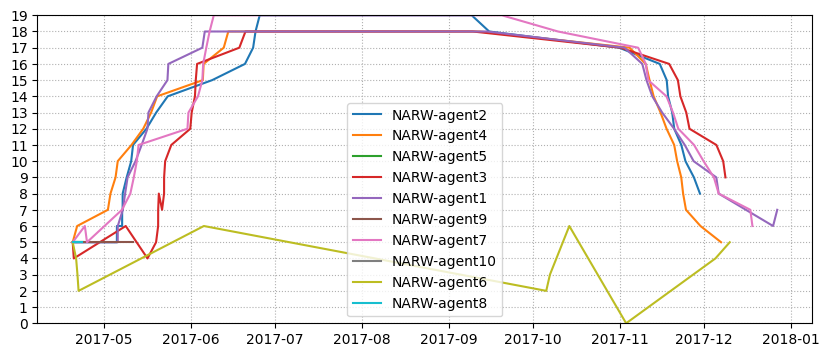

In [23]:
#plot migrations
plt.figure(figsize=(10,4))
for agent_id in ds.agents.index:
    mig = migrations.loc[agent_id].sort_values()
    plt.plot(mig.values, mig.index, label=agent_id)

plt.yticks(range(len(polygons)+1))
plt.ylim(0, len(polygons))
plt.grid(linestyle=':')
plt.legend()


## It looks like some agents never really left the beginning, or exited the domain completely early on in the simulation.

## We can use the same polygons to now develop a map of the amount of time spent in each.

In [24]:
#empty container
_spent = {}

#loop over polygons
for i in range(len(polygons)):
    #get time spent in polygon
    spent = ds.time_in_polygon(polygons.iloc[i].geometry,
                            meta_cols=['Agent ID'],
                            data_cols=['Time','X','Y'])
    #if none
    if len(spent)==0:
        dur = 0
    #otherwise sum
    else:
        dur = spent['Duration'].sum()
    #add to dict
    _spent[polygons.iloc[i]['Code']] = dur

Computing time spent in polygon: 100%|██████████| 10/10 [00:00<00:00, 153.30it/s]


<Axes: title={'center': 'Time Spent (total days all agents)'}>

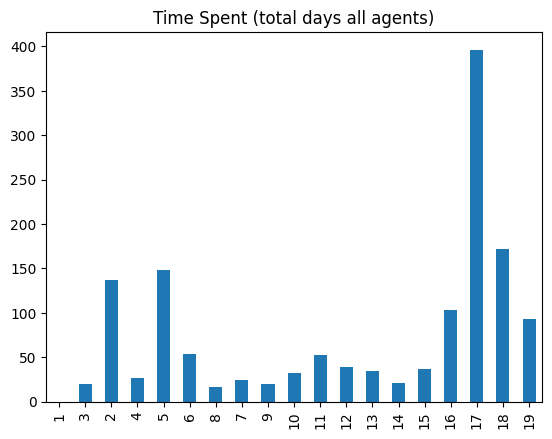

In [25]:
#convert to df
spent = pd.DataFrame([_spent]).T / 86400
spent.plot.bar(legend=False, title='Time Spent (total days all agents)')

<Axes: >

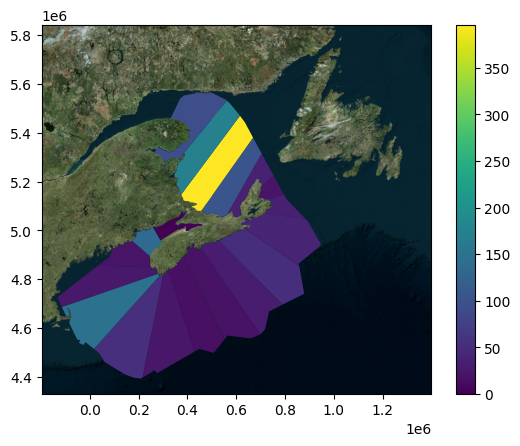

In [26]:
#map plot of the same
plt.figure()
bm = rio.open('basemap.tif', 'r')
ax = show(bm, zorder=0, ax=plt.gca())
polygons['spent'] = spent.loc[polygons['Code'].values].values
polygons.plot(column='spent', legend=True, ax=ax)

## Finally, let's create some monthly heatmaps.

At the moment, the easiest way to perform temporal filtering of track is by simply filtering the dataframe of the track data.

Just a note, the rasterizing function depends on there being a GIS file of tracks to rasterize. We can write GIS file by first converting data to a `GeoDataFrame`. Also, we know that the `Dataset.to_gdf` method has the ability to split/segment tracks based on boolean Code values.

Putting the above two points together, the easiest way to create heatmaps of temporally chunked tracks (without simply processing the raw data in chunks to begin with) is by adding Code values to the tracks.

In [27]:
#create a dynamic data mapper for the Time column
_mapper = ds.make_data_mapper(['Time']) #I'm not sure why these are coming out as int (ns) units - notebook forcing np.int32 dtype??

#fix this in the output
mapper = {}

#add the month to the mapper
for k in _mapper.keys():
    time = pd.to_datetime(k)
    mapper[time] = time.month

Making data mappers: 100%|██████████| 10/10 [00:00<00:00, 297.90it/s]


In [28]:
#map this to the dataset
ds = ds.map_data(['Time'], 
                 ['Month'], 
                 {'Time':mapper})

Mapping agent dynamic data: 100%|██████████| 10/10 [00:00<00:00, 45.23it/s]


In [29]:
#convert int column to codes
code_mapper = {i:i for i in range(1,13)}
ds = ds.map_data_to_codes(['Month'], 
                          {'Month':code_mapper})

Mapping agent dynamic data to coded boolean arrays: 100%|██████████| 10/10 [00:00<00:00, 64.57it/s]


## Now let's create a blank raster, loop over the months, create a GPKG file, and rasterize the track counts.

In [30]:
#define blank raster output file
blank_file = 'blank.tif'

#get bounds of dataset
x0, y0, x1, y1 = ds.agents.total_bounds

#create blank zero raster 25km x 25km
tio.create_blank_raster(blank_file,
                        ds.meta['CRS'],
                        grid={'x0': x0,
                              'y0': y0,
                              'nx': int((x1-x0)/25000),
                              'ny': int((y1-y0)/25000),
                              'dx': 25000,
                              'dy': 25000})

Raster created and saved to blank.tif!


In [31]:
#loop over the months
for i in range(1,13):
    #get monthly gdf
    tmp = ds.to_gdf(code=i)
    #remove old tmp file
    if os.path.isfile('tmp.gpkg'):
        os.remove('tmp.gpkg')
    #if the gdf is empty - i.e. nothing present
    if len(tmp)==0:
        continue
    #write to tmp file
    tmp.to_file('tmp.gpkg')
    #rasterize the track counts
    tio.rasterize('tmp.gpkg', blank_file, f'month{i}.tif')

Converting tracks to GeoDataFrame: 100%|██████████| 10/10 [00:00<00:00, 400.10it/s]


Track Counts written to c:\code\trackio\notebooks\example2_ABM_output\month4.tif


Converting tracks to GeoDataFrame: 100%|██████████| 10/10 [00:00<00:00, 300.16it/s]


Track Counts written to c:\code\trackio\notebooks\example2_ABM_output\month5.tif


Converting tracks to GeoDataFrame: 100%|██████████| 10/10 [00:00<00:00, 312.42it/s]


Track Counts written to c:\code\trackio\notebooks\example2_ABM_output\month6.tif


Converting tracks to GeoDataFrame: 100%|██████████| 10/10 [00:00<00:00, 310.02it/s]


Track Counts written to c:\code\trackio\notebooks\example2_ABM_output\month7.tif


Converting tracks to GeoDataFrame: 100%|██████████| 10/10 [00:00<00:00, 343.01it/s]

Track Counts written to c:\code\trackio\notebooks\example2_ABM_output\month8.tif



Converting tracks to GeoDataFrame: 100%|██████████| 10/10 [00:00<00:00, 344.84it/s]


Track Counts written to c:\code\trackio\notebooks\example2_ABM_output\month9.tif


Converting tracks to GeoDataFrame: 100%|██████████| 10/10 [00:00<00:00, 333.26it/s]


Track Counts written to c:\code\trackio\notebooks\example2_ABM_output\month10.tif


Converting tracks to GeoDataFrame: 100%|██████████| 10/10 [00:00<00:00, 285.71it/s]


Track Counts written to c:\code\trackio\notebooks\example2_ABM_output\month11.tif


Converting tracks to GeoDataFrame: 100%|██████████| 10/10 [00:00<00:00, 421.44it/s]


Track Counts written to c:\code\trackio\notebooks\example2_ABM_output\month12.tif


In [32]:
#get heatmap file  sorted by month - there's 9
heatmap_files = sorted(glob.glob('month*.tif'), key=lambda x: int(x.replace('month','').replace('.tif','')))

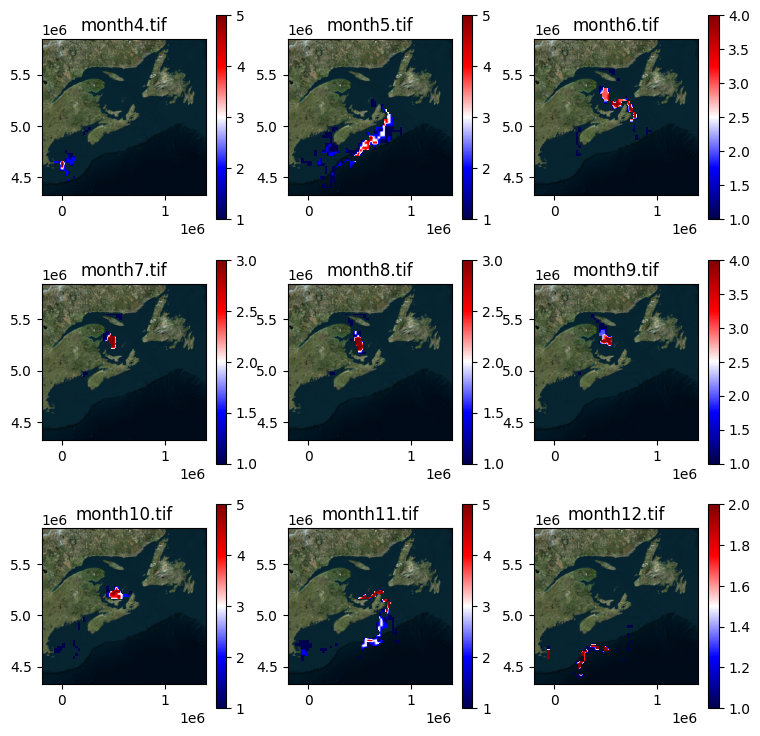

In [33]:
#plot heatmaps
bm = rio.open('basemap.tif', 'r')
fig, ax = plt.subplots(3, 3, figsize=(9,9))
for file,a in zip(heatmap_files, ax.flatten()):
    show(bm, zorder=0, ax=a)
    a.set_xlim(a.get_xlim())
    a.set_ylim(a.get_ylim())
    ras = rio.open(file, 'r')
    show(ras, ax=a, cmap='seismic')
    a.set_title(file)
    plt.colorbar(a.get_images()[1])

## If we do a proximity analysis, we can determine the whales that spent the most time close to one another.

***Note, the timestamps of the ABM model output are the same for the agents, they already have the same global time axis. If this was not the case, you should run `Dataset.resample_time_global` first.***

In [34]:
#agent proximities, binned distances time spent
bins = [1000,
        5000,
        10000,
        20000,
        30000,
        50000,
        75000,
        100000]
proximities = ds.proximities(bins=bins, relative=False)

Proximity analysis assumes that self.resample_time_global has already been run, if not the results will be invalid or the function may fail


Calculating track proximities: 100%|██████████| 45/45 [00:01<00:00, 37.93it/s]


In [35]:
#groupby agents and then find the pair who spent the most time near one another
grouped = proximities.groupby(['Track ID_0','Track ID_1'])[bins].agg(sum)

#most time spent <= 10km of eachother
idx = grouped[[1000,5000,10000]].values.sum(axis=1).argmax()

tracks = grouped.iloc[idx].name

<Axes: >

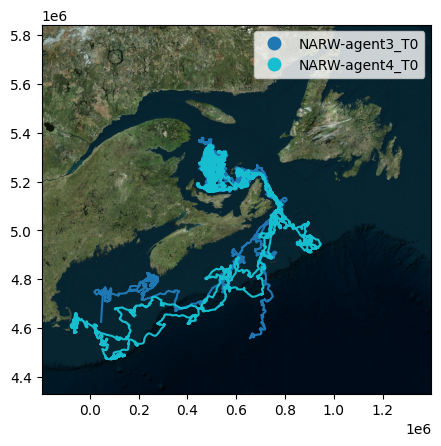

In [36]:
#plot the two
plt.figure()
bm = rio.open('basemap.tif', 'r')
ax = show(bm, zorder=0, ax=plt.gca())
gdf[gdf['Track ID'].isin(tracks)].plot(column='Track ID', ax=ax, legend=True)

## And we can plot the distance between the two over time.

Text(0.5, 1.0, 'Distance Apart (km)')

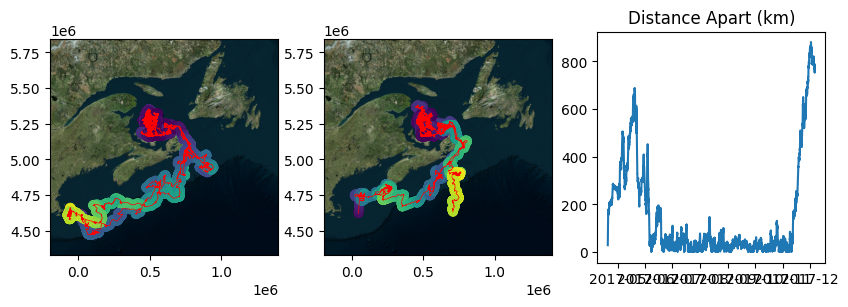

In [37]:
#get tracks
t1 = ds.get_track(tracks[0])
t2 = ds.get_track(tracks[1])

#filter to common timesteps
t1 = t1[t1['Time'].isin(t2['Time'])]
t2 = t2[t2['Time'].isin(t1['Time'])]

#distance apart
distance = ((t1['X'] - t2['X'])**2 + (t1['Y'] - t2['Y'])**2)**0.5

#plot
fig, ax = plt.subplots(1,3, figsize=(10,3))
show(bm, zorder=0, ax=ax[0])
show(bm, zorder=0, ax=ax[1])
ax[0].scatter(t1['X'], t1['Y'], c=distance)
ax[1].scatter(t2['X'], t2['Y'], c=distance)
ax[0].plot(t1['X'], t1['Y'], c='r', linewidth=0.5)
ax[1].plot(t2['X'], t2['Y'], c='r', linewidth=0.5)
ax[2].plot(t1['Time'], distance/1000)
ax[2].set_title('Distance Apart (km)')